In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit
from collections import defaultdict
%load_ext autoreload
%autoreload 2

## Load the training data into feature matrix, class labels, and event ids:

In [2]:
from proj1_helpers import *
from implementations import *

DATA_TRAIN_PATH = 'train.csv' # path to train set
DATA_TEST_PATH = 'test.csv'   # path to test set
OUTPUT_PATH = 'out.csv'       # path to output

init_train_y, init_train_x, ids_train = load_csv_data(DATA_TRAIN_PATH, sub_sample=False)
_, init_test_x, ids_test = load_csv_data(DATA_TEST_PATH)

init_train_y = (init_train_y + 1.0) * 0.5

np.random.seed(1)

## Utility methods
When you add your own methods, please add a short description so that we all know what it does

In [83]:
def cropped_of_rows_with_999_value(x, y):
    """Returns updated x and y such that all row which contained
       at least one value = -999 are removed"""
    for i in range(x.shape[1]):
        idxes = (x[:, i] != -999)
        x = x[idxes]
        y = y[idxes]
    return x, y

def columns_with_999_value(x):
    """Returns the indices of all the columns which have at least one element = -999"""
    indexes = []
    for i in range(x.shape[1]):
        if np.any(x[:, i] == -999):
            indexes.append(i)
    return indexes

def column_mean_without_999(col):
    """Returns the mean of the vector without taking into account values = -999"""
    return np.mean(col[col[:] != -999])

def replace_999_with(col, val):
    """Replaces every element = -999 with the given value"""
    col[col[:] == -999] = val

def columns_with_low_corr(x, y):
    """Returns the indices of the columns which have a 
       'low' correlation to the output. (Experimental)"""
    indexes = []
    for i in range(x.shape[1]):
        if np.abs(np.corrcoef(x[:, i], y)[0][1]) < 0.05:
            indexes.append(i)
    return indexes

def cropped_of_columns(x, columns_indexes):
    """Returns a copy of x where the columns indexed by columns_indices are removed"""
    return np.delete(x, columns_indexes, axis = 1)

def get_999_indices_tuples(x):
    indices = defaultdict(lambda: [], {})
    for i in range(x.shape[0]):
        indices[tuple(x[i] == -999)].append(i)
    return indices

def augment(x, degree):
    """Returns x concatenated with x ** 2, ..., x ** n"""
    return x if degree == 1 else np.append(augment(x, degree - 1), x ** degree, axis = 1)

## Pipeline definitions

In [4]:
class BasePhase(object):
    """Base class for phases"""
    pass

class Foreach(BasePhase):
    def __init__(self, names, subpipe):
        self.names = names
        self.subpipe = subpipe
        
    def run(self, args):
        items = [(name, args[name]) for name in self.names]
        if len(items) > 0:
            ret = {}
            for i in range(len(items[0][1])):
                substate = {name: val[i] for name, val in items}
                run_pipeline(self.subpipe, substate)

                for key, val in substate.items():
                    if key in ret: ret[key].append(val)
                    else: ret[key] = [val]

            return ret

def run_pipeline(pipeline, args):
    for phase in pipeline:
        ret = phase.run(args)
        if ret is not None: args.update(ret)

## Initialisation phases

25


C:\Users\Romain\Anaconda3\lib\site-packages\ipykernel\__main__.py:33: RuntimeWarning: divide by zero encountered in true_divide


9


C:\Users\Romain\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2569: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\Romain\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2570: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


27
1
26
2


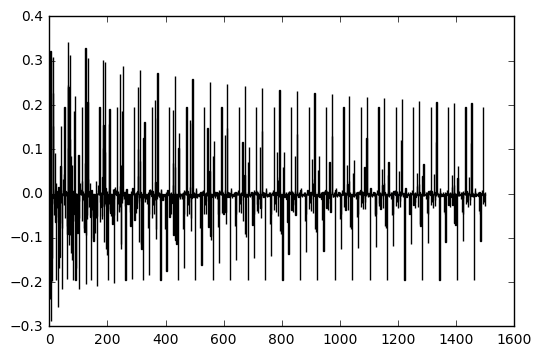

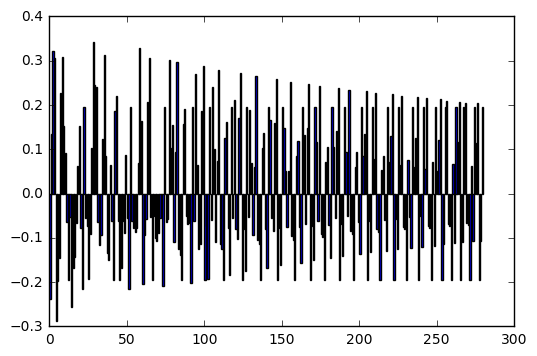

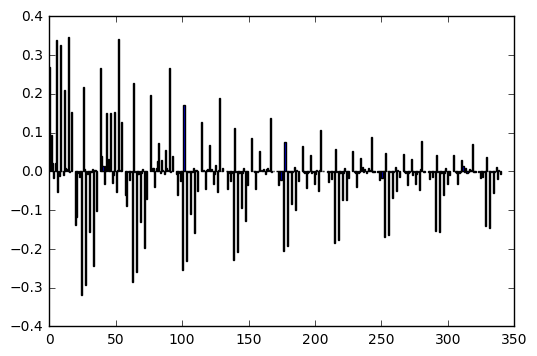

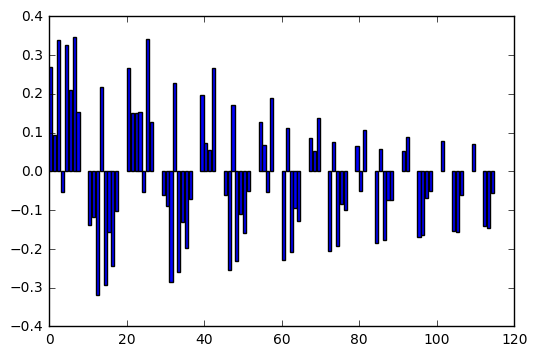

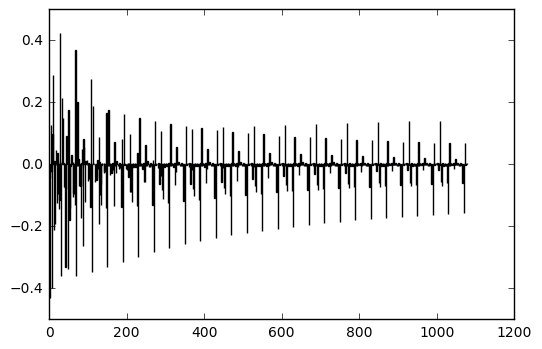

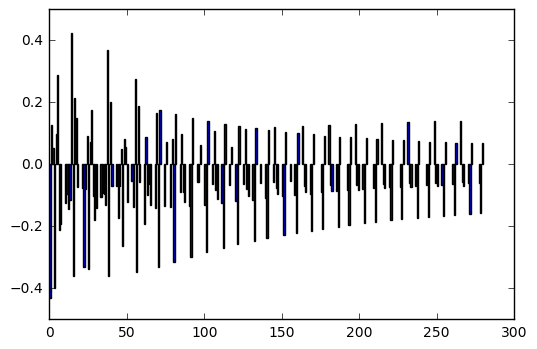

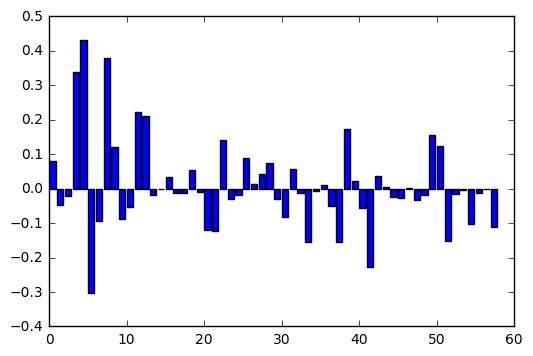

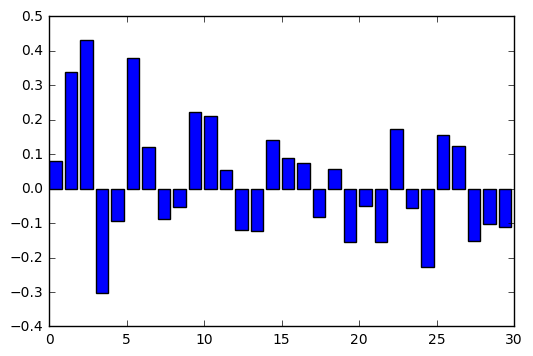

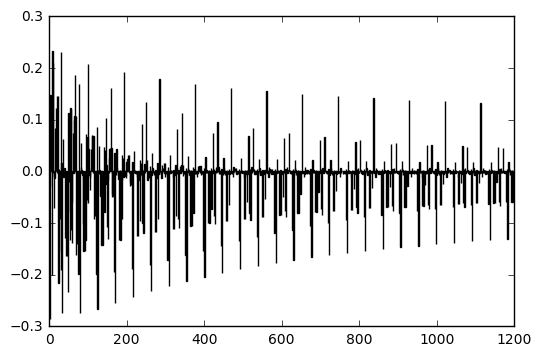

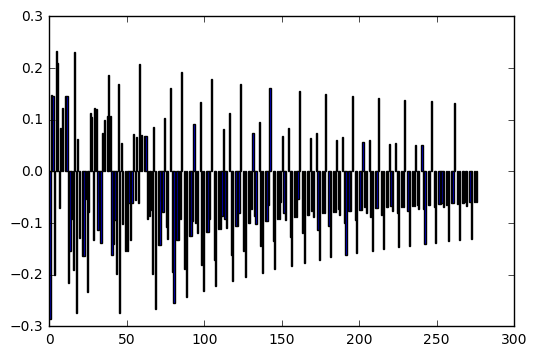

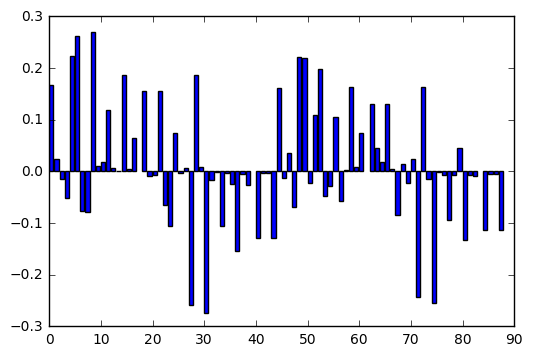

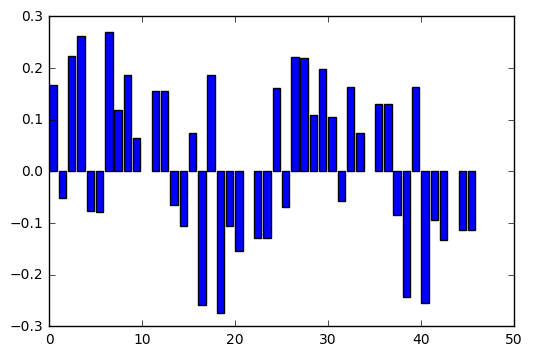

In [86]:
class InitPhase(BasePhase):
    """Copies the train and test set before executing next phase"""
    def run(self, args):
        ret = {}
        ret["train_x"] = np.copy(args["init_train_x"])
        ret["train_y"] = np.copy(args["init_train_y"])
        if "init_test_x" in args:
            ret["test_x"] = np.copy(args["init_test_x"])
        return ret

class StandardizePhase(BasePhase):
    """Standardize the dataset"""
    def run(self, args):
        ret = {}
        ret["train_x"], mean, var = standardize(args["train_x"])
        if "test_x" in args:
            ret["test_x"], _, _ = standardize(args["test_x"])
        
        return ret

class AugmentPhase(BasePhase):
    """Augments the dataset to the given degree n"""
    def __init__(self, n):
        self.n = n
        
    def run(self, args):
        ret = {}
        sample_count = len(args["train_y"])
        degree = max(int(self.n * sample_count / 40000), 1)
        print(degree)
        datasets = ["train_x"] + (["test_x"] if "test_x" in args else [])
        for name in datasets:
            inv = 1.0 / args[name]
            idx = (inv == float('+inf'))
            inv[idx] = args[name][idx]
            ret[name] = augment(np.append(args[name], inv, axis = 1), degree)
        
        return ret

class Replace999ByColumnMeanPhase(BasePhase):
    """Replaces cells = -999 with their respective column's mean"""
    def run(self, args):
        train_x = args["train_x"]
        for i in range(train_x.shape[1]):
            col = train_x[:, i]
            mean = column_mean_without_999(col)
            replace_999_with(col, mean)
        
        if "test_x" in args:
            test_x = args["test_x"]
            for i in range(train_x.shape[1]):
                col = test_x[:, i]
                mean = column_mean_without_999(col)
                replace_999_with(col, mean)
    
class RemoveLowCorrelationFeaturesPhase(BasePhase):
    """Replaces cells = -999 with their respective column's mean"""
    def run(self, args):
        train_x, train_y = args["train_x"], args["train_y"]
        indices = columns_with_low_corr(train_x, train_y)
        train_x = cropped_of_columns(train_x, indices)
        
        if "test_x" in args:
            test_x = cropped_of_columns(args["test_x"], indices)
            
        return {"train_x": train_x, "test_x": test_x}

class SplitUpon999Phase(BasePhase):
    """Splits the dataset according to some -999 criterion"""
    def run(self, args):
        train_x, train_y = args["train_x"], args["train_y"]
        
        ret = {"train_row_indices": [], "train_x": [], "train_y": []}
        
        if "test_x" in args:
            test_x = args["test_x"]
            test_map = get_999_indices_tuples(test_x)
            ret["test_row_indices"] = []
            ret["test_x"] = []
        else:
            test_x = None
        
        for col_indices, row_indices in get_999_indices_tuples(train_x).items():
            ret["train_row_indices"].append(row_indices)
            ret["train_x"].append(np.delete(train_x[row_indices], np.where(col_indices), axis = 1))
            ret["train_y"].append(train_y[row_indices])
            
            if test_x is not None:
                test_row_indices = test_map[col_indices]
                ret["test_row_indices"].append(test_row_indices)
                ret["test_x"].append(np.delete(test_x[test_row_indices], np.where(col_indices), axis = 1))
        
        return ret
    
class PlotFeatureOutputCorrelationPhase(BasePhase):
    """Plots feature to output correlation chart graph"""
    def run(self, args):
        train_x, train_y = args["train_x"], args["train_y"]
        feature_count = train_x.shape[1]

        corrs = np.zeros(feature_count)
        for i in range(feature_count):
            feature = train_x[:, i]
            corrs[i] = np.corrcoef(feature, train_y)[0][1]

        fig, ax = plt.subplots()

        ax.bar(np.arange(feature_count), corrs)
        
class PlotGramMatrixPhase(BasePhase):
    """Plots the Gram matrix"""
    def run(self, args):
        train_x = args["train_x"]
        G = train_x.T @ train_x
        plt.matshow(G, cmap = plt.cm.gray)

init_pipeline = [
    InitPhase(),
    Replace999ByColumnMeanPhase(),
    AugmentPhase(6),
    RemoveLowCorrelationFeaturesPhase(),
    PlotFeatureOutputCorrelationPhase(),
    StandardizePhase()
]

test_pipeline = [
    InitPhase(),
    SplitUpon999Phase(),
    Foreach(["train_x", "train_y", "test_x"], [
        AugmentPhase(15),
        PlotFeatureOutputCorrelationPhase(),
        RemoveLowCorrelationFeaturesPhase(),
        PlotFeatureOutputCorrelationPhase(),
        StandardizePhase()
    ])
]

state = {
    "init_train_x": init_train_x, 
    "init_train_y": init_train_y, 
    "init_test_x": init_test_x,
    "ids_test": ids_test
}

run_pipeline(test_pipeline, state)

## Training phases

In [90]:
class CrossValidationPhase(BasePhase):
    def __init__(self, k_fold, pred_subpipe):
        self.k_fold = k_fold
        self.pred_subpipe = pred_subpipe
        
    def _build_k_indices(self, num_row):
        """build k indices for k-fold."""
        interval = int(num_row / self.k_fold)
        indices = np.random.permutation(num_row)
        k_indices = [indices[k * interval: (k + 1) * interval] for k in range(self.k_fold)]
        return np.array(k_indices)

    def _cross_validation(self, y, tx, k_indices, k):
        """return the loss of ridge regression."""
        tmp_y = np.delete(y[k_indices], k, 0)
        tmp_x = np.delete(tx[k_indices], k, 0)
        train_y = tmp_y.reshape(tmp_y.shape[0] * tmp_y.shape[1])
        train_x = tmp_x.reshape((tmp_x.shape[0] * tmp_x.shape[1], tmp_x.shape[2]))
        test_y  = y[k_indices[k]]
        test_x  = tx[k_indices[k]]

        state = {"train_x": train_x, "train_y": train_y}
        run_pipeline(self.pred_subpipe, state)
        pred = state["pred"]
        
        train_y_pred = pred.predict(train_x)
        test_y_pred  = pred.predict(test_x)

        train_y_err = np.count_nonzero(train_y_pred == train_y) / len(train_y)
        test_y_err  = np.count_nonzero(test_y_pred  == test_y ) / len(test_y)

        return train_y_err, test_y_err
    
    def run(self, args):
        train_x, train_y = args["train_x"], args["train_y"]
        k_fold = 4
        k_indices = self._build_k_indices(len(train_y))
        print("Cross Validation:")
        for k in range(k_fold):
            train_err, test_err = self._cross_validation(train_y, train_x, k_indices, k)
            print("#%s fold: (Train error: %s, Test error: %s)" % (k, train_err, test_err))
            
class TrainBasicPredictorPhase(BasePhase):
    """Trains a predictor with the given train set"""
    def __init__(self, gamma, max_iters):
        self.gamma = gamma
        self.max_iters = max_iters
        
    def run(self, args):
        train_x, train_y = args["train_x"], args["train_y"]
        w, _ = logistic_regression(train_y, train_x, np.zeros(train_x.shape[1]), self.max_iters, self.gamma)
        return {"pred": Predictor(w)}
    
class Predictor(object):
    def __init__(self, w):
        self.w = w
    
    def predict(self, x):
        y_pred = expit(x @ self.w)

        y_pred[y_pred <  0.5] = 0
        y_pred[y_pred >= 0.5] = 1

        return y_pred

trainPredictPhase = TrainBasicPredictorPhase(0.1, 2000)

train_pipeline = [
    #CrossValidationPhase(4, [trainPredictPhase]),
    trainPredictPhase
]

test_train_pipeline = [
    Foreach(["train_x", "train_y"], train_pipeline)
]

run_pipeline(test_train_pipeline, state)

## Prediction phases

In [91]:
total_train_error = 0
total_train_samples = 0

class PredictionOnTrainSetPhase(BasePhase):
    """Predicts the output of the given dataset"""
    def run(self, args):
        train_x, train_y, pred = args["train_x"], args["train_y"], args["pred"]
        y_pred = pred.predict(train_x)
        global total_train_error
        global total_train_samples
        total_train_error += np.count_nonzero(y_pred == train_y)
        total_train_samples += len(train_y)
        print(np.count_nonzero(y_pred == train_y) / len(train_y), " for ", len(train_y), " points")

class PredictionOnTestSetPhase(BasePhase):
    def run(self, args):
        test_x, pred = args["test_x"], args["pred"]
        y_pred = pred.predict(test_x)
        return {"y_pred": y_pred}
        
class AggregateBackPredictionsFrom999SplitPhase(BasePhase):
    """Aggregates predictions"""
    def run(self, args):
        y_preds, row_indices = args["y_pred"], args["test_row_indices"]
        
        ret = {}
        
        total = 0
        for i in range(len(row_indices)):
            total += len(row_indices[i])
            
        y_pred = np.zeros(total)
        for i in range(len(row_indices)):
            y_pred[row_indices[i]] = y_preds[i]
            
        return {"y_pred": y_pred}
        
class CreateSubmissionPhase(BasePhase):
    """Creates the CSV submission file from the given predictions"""
    def run(self, args):
        y_pred, ids_test = args["y_pred"], args["ids_test"]
        create_csv_submission(ids_test, y_pred * 2 - 1, OUTPUT_PATH)
        
test_pred_pipeline = [
    Foreach(["train_x", "train_y", "test_x", "pred"], [
        PredictionOnTrainSetPhase(),
        PredictionOnTestSetPhase()
    ]),
    AggregateBackPredictionsFrom999SplitPhase(),
    CreateSubmissionPhase()
]

run_pipeline(test_pred_pipeline, state)

print("Total: ", total_train_error / total_train_samples)

0.8251313973632439  for  68114  points
0.9513072771121234  for  26123  points
0.8083209106925058  for  73790  points
0.9119440054188305  for  4429  points
0.792075105027007  for  69982  points
0.9180111081724411  for  7562  points
Total:  0.828448
